- ver0.0 2025/10/27 シェブロンパターン測定まで準備 (小川)
- ver0.1 2025/10/28 全体を微修正, qubitの基本測定とラビ振動の規格化を追加 (小川)

<span style="color: red; ">**examples/1Q-calibrationのフォルダをご自身のworkspaceに移動させてから, 実験を行ってください.**</span>

## クラウド設定

一度だけ実行すれば良い.

In [ ]:
# from pathlib import Path

# config = """[default]
# url=https://api.qiqb-cloud.jp
# api_token=xxxxxxx
# """
# Path("~/.oqtopus").expanduser().write_text(config)
# print("Configuration saved.")

Configuration saved.


QIQBクラウドのリンク：https://www.qiqb-cloud.jp/  
  
「ジョブ」のタブで, 実行済み・実行中のジョブを確認することができます. 

## 1qubitの較正 

In [6]:
from quri_parts_oqtopus.backend import OqtopusSseBackend
from oqtopus_sse_pulse.adapter import QuriAdapter, collect_payloads_from_job, collect_session_from_job
from oqtopus_sse_pulse.plotters import plot_payload

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

DEVICE = "anemone" # デバイス名 (勉強会ではanemoneに固定)
backend = OqtopusSseBackend() # OqtopusSseBackendのインスタンスを作成

In [2]:
def experiment(program: str) -> list:
    """
    指定した実験プログラムを実行し, 測定結果のペイロードを返す関数.
    """

    # ジョブの実行
    job = backend.run_sse(
        file_path=f"{program}.py",
        device_id=f"{DEVICE}-pulse",
        name=program,
    )
    print(f"job_id = {job.job_id}")

    # ジョブの完了待ち
    job.wait_for_completion()
    print(f"job_status = {job.status}  elapsed={job.execution_time}")

    # QuriAdapterの作成
    adapter = QuriAdapter(backend)

    # 測定結果の取得
    payloads = collect_payloads_from_job(
        backend=adapter,
        job_id=job.job_id,
    )
    
    return payloads

### シェブロンパターン測定

まずは試しに, `1Q-calib-1_chevron_pattern.py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してみてください. 

job_id = 06900c40-74e3-73f4-8000-f0c51efc39da
job_status = succeeded  elapsed=44.093


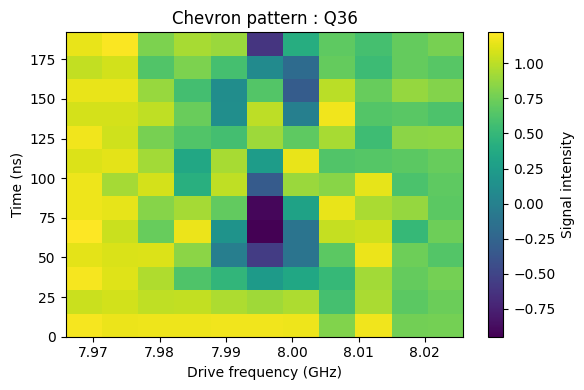

In [7]:
payloads = experiment("1Q-calib-1_chevron_pattern")

# グラフ描画
p = payloads[0]
fig, ax = plot_payload(p, program="1Q-calib-1_chevron_pattern")

<span style="color: red; ">**[自主作業1] 得られたシェブロンパターンから, このqubitの共鳴周波数を求めてください.**</span> 
- 各駆動周波数におけるラビ振動をフーリエ変換して各ラビ周波数を計算し, それらのデータ点にフィッティングを行うことにより, ラビ振動が最小となる駆動周波数を算出することができます. 
- フィッティング関数は以下を使用してください:
$$ f_{\rm rabi} = \sqrt{(f_{\rm q} - f_{\rm d})^2 + f_{\rm rabi,min}^2} $$
- ここで$f_{\rm rabi}$は各駆動周波数におけるラビ振動周波数, $f_{\rm q}$はqubitの共鳴周波数, $f_{\rm d}$はマイクロ波駆動周波数, $f_{\rm rabi,min}$は共鳴駆動条件で現れる最小ラビ振動周波数です. $f_{\rm d}$は掃引パラメータ, $f_{\rm q}$, $f_{\rm rabi,min}$はフィッティングによって決定されるパラメータです.  

[補足]
- マイクロ波駆動振幅を大きくすると, それに比例してラビ振動周波数が大きくなりますが, それだけでなく, 上記フィッティングで得られるqubit共鳴周波数にも微小なシフトが観測されるはずです. これはac-シュタルク効果と呼ばれる現象で, 一般にマイクロ波駆動中のqubitは駆動の影響を受けてその共鳴周波数が微小にシフトします. ゲート忠実度を突き詰める場合には, DRAGなどのテクニックによってこのシフトの影響を考慮したパルス設計を行う必要があります. 
- シェブロンパターンを細かく測定すると, qubitの共鳴とは別に細い共鳴信号が見えることがあります. これは多くの場合, トランズモン中または近くの不純物によって生じる不要2準位系(two-level system: TLS)の共鳴が見えているものだと考えられています. TLSの共鳴周波数がqubitの共鳴周波数に近かったり, qubitとの結合が大きかったりすると, qubitのコヒーレンス性能の悪化をもたらします. さらにTLSは数時間〜数日の時間スケールで特性が変化することがあり, これがqubitの時間安定性にも影響を与えることがあります. 

### qubitの基本測定

上のシェブロンパターン測定では, お試し測定という意味で, ラビ振動測定のパルスシーケンスや読み出しリターン信号が適切に処理されるように準備されたメソッドを用いました.  
これ以降ではパルスレベル実験の基礎を学ぶために, 基本的な測定実験から始めていきます.    

`1Q-calib-2_measure.py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してみてください. 

In [3]:
payloads = experiment("1Q-calib-2_measure")

job_id = 06900c75-e5d5-797a-8000-4e61b9dedb29
job_status = succeeded  elapsed=8.226


この実験では, 最も基本的なqubit測定メソッドである`measure`メソッドを用いて, `waveform = [0.1 + 0.1j, 0.1 + 0.1j, 0.1 + 0.1j, 0.1 + 0.1j, 0.1 + 0.1j]`によって定義された波形をqubitに照射して, 読み出し波形の取得を行っています.   
返ってきた`payloads`のうち, `"raw_data_real"`および`"raw_data_imag"`には読み出しパルス波形 (`mode="avg"`と選択時には`shots=1024`回分の積算波形) の実部および虚部のリスト, `"time_range"`には対応する時間リスト, `"kerneled_data_real"`および`"kerneled_data_imag"`には読み出しパルス波形を時間平均した値が格納されています.  
通常はkerneled dataの複素数1つを見て, この実験状況における測定結果を読み取ります. 
以下ではそれらをグラフに描画してみます. 

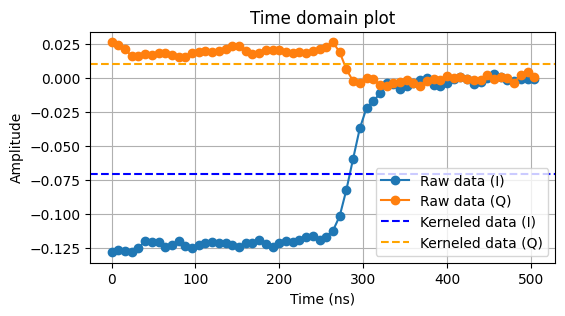

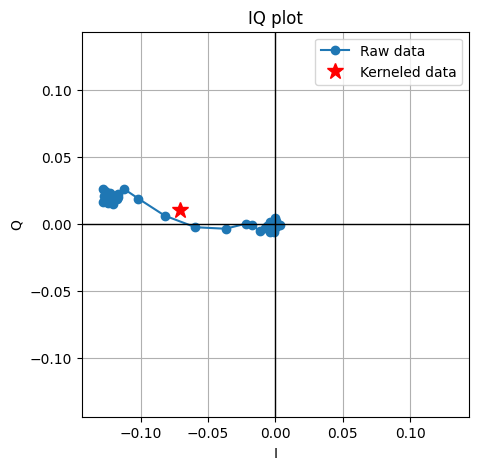

In [9]:
# 測定で得られた全データ
raw_data_real = payloads[0]["raw_data_real"]
raw_data_imag = payloads[0]["raw_data_imag"]
kerneled_data_real = payloads[0]["kerneled_data_real"]
kerneled_data_imag = payloads[0]["kerneled_data_imag"]
t_list = payloads[0]["time_range"]

# 時間プロットを表示
plt.figure(figsize=(6, 3))
plt.plot(t_list, raw_data_real, 'o-', label='Raw data (I)')
plt.plot(t_list, raw_data_imag, 'o-', label='Raw data (Q)')
# kerneled_dataの横線を引く
plt.axhline(kerneled_data_real, linestyle='--', color='b', label='Kerneled data (I)')
plt.axhline(kerneled_data_imag, linestyle='--', color='orange', label='Kerneled data (Q)')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude')
plt.title('Time domain plot')
plt.legend()
plt.grid(True)
plt.show()

# IQプロットを表示
plt.figure(figsize=(5,5))
plt.plot(raw_data_real, raw_data_imag, 'o-', label='Raw data')
plt.plot(kerneled_data_real, kerneled_data_imag, '*', label='Kerneled data', markersize=12, color='red')
plt.axhline(0, linewidth=1, color='k') # x, y軸に直線を引く
plt.axvline(0, linewidth=1, color='k')
max = np.max(np.sqrt(np.array(raw_data_real)**2 + np.array(raw_data_imag)**2)) * 1.1 # 原点を中心にする
plt.xlim(-max, max)
plt.ylim(-max, max)
plt.xlabel('I')
plt.ylabel('Q')
plt.title('IQ plot')
plt.legend()
plt.grid(True)
plt.show()


[補足]
- ここではパルス波形をリストの形であらわに書き下して定義しましたが, `np.exp()`や`np.cos()`といった関数を用いて解析的に表せる形のnumpy.ndarrayでもOKです. 
- `qubex.pulse`にはさまざまな実用的なパルス波形が定義されています. `from qubex.pulse import ...`でインポートしてご使用いただいてもOKです. 

### ラビ振動の規格化

ここでは, 改めてラビ振動を観測する実験を行い, 読み出しリターン信号のIQ平面上での振る舞いを観察します.  
`1Q-calib-3_rabi.py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してください. 

In [11]:
payloads = experiment("1Q-calib-3_rabi")

job_id = 06900d03-395a-7772-8000-1e0ad75159b1
job_status = succeeded  elapsed=19.196


この実験では`sweep_parameter`メソッドを用いて, 矩形波`[ampl] * int(T/2)`の長さ`T`を掃引しながら, ラビ振動の測定を行っています.   
返ってきた`payloads`の`"data_real"`および`"data_imag"`には, 各パルス長さ`T`の時のqubit読み出し結果のkerneled dataの実部および虚部,  `"time_range"`には対応するパルス時間リストが格納されています.  
以下ではそれらをグラフに描画してみます. 

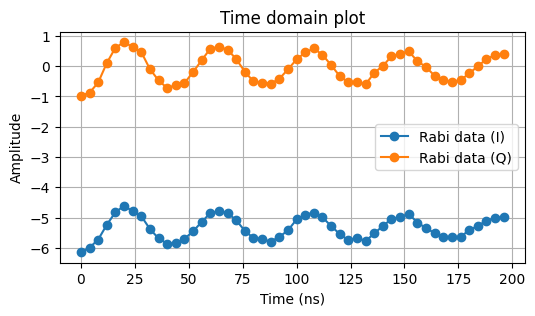

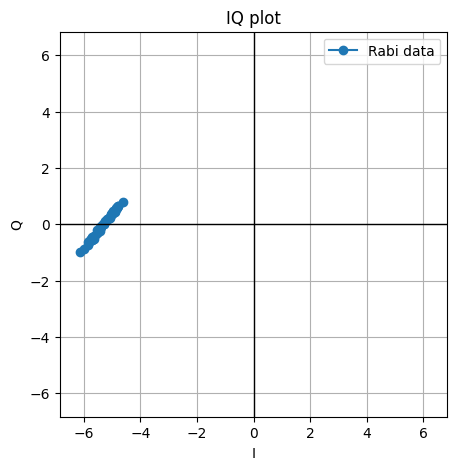

In [15]:
# 測定で得られた全データ
data_real = payloads[0]["data_real"]
data_imag = payloads[0]["data_imag"]
t_list = payloads[0]["time_range"]

# 時間プロットを表示
plt.figure(figsize=(6, 3))
plt.plot(t_list, data_real, 'o-', label='Rabi data (I)')
plt.plot(t_list, data_imag, 'o-', label='Rabi data (Q)')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude')
plt.title('Time domain plot')
plt.legend()
plt.grid(True)
plt.show()

# IQプロットを表示
plt.figure(figsize=(5,5))
plt.plot(data_real, data_imag, 'o-', label='Rabi data')
plt.axhline(0, linewidth=1, color='k') # x, y軸に直線を引く
plt.axvline(0, linewidth=1, color='k')
max = np.max(np.sqrt(np.array(data_real)**2 + np.array(data_imag)**2)) * 1.1 # 原点を中心にする
plt.xlim(-max, max)
plt.ylim(-max, max)
plt.xlabel('I')
plt.ylabel('Q')
plt.title('IQ plot')
plt.legend()
plt.grid(True)
plt.show()


<span style="color: red; ">**[自主作業2] このIQ平面上の振動を, Z期待値 $\langle Z \rangle \in[-1,1]$に対応させる関数`z_expectation_value()`を作成してください.**</span> 
- IQ平面上において, ラビ振動の開始点は$|\rm g\rangle$状態, その反対側の点は$|\rm e\rangle$状態に対応します. それらの点は, Z期待値 $\langle Z \rangle \in[-1,1]$の$+1$, $-1$にそれぞれ対応します. 
- したがって上記のラビ振動測定結果の`data_real = payloads[0]["data_real"]`, `data_imag = payloads[0]["data_imag"]`を用いることで, (実部, 虚部)→Z期待値 と変換させる関数`z_expectation_value(real, imag)`が定義できるはずです. 
- 振動軸の傾きや切片の取得は, 主成分分析(PCA)を用いると便利です. `from sklearn.decomposition import PCA`でインポートできます. 
- 振動軸方向の振動に対して, 減衰振動曲線でフィッティングを行い, ラビ振動の振幅と定数オフセットを取得します. これらを用いると(実部, 虚部)→Z期待値 の変換が計算できるはずです. 
- 減衰振動曲線でフィッティングにおけるラビ振動数の初期値は, ラビ振動をフーリエ変換してピークとなる周波数成分を取得しておくとこれが利用できます. 

In [16]:
def z_expectation_value(real: float, imag: float) -> float:
    """
    IQ平面上の点(real, imag)をZ期待値 <Z> ∈ [-1, 1] に変換する関数.
    """
    # ここにコードを記述してください.
    pass

### π/2パルス較正 (TBD)

### コヒーレンス測定 (TBD)

#### T1測定 (TBD)

#### T2 echo測定 (TBD)

#### Ramsey干渉実験 (TBD)

### 読み出し分類機調整 (TBD)

### Randomized Benchmarking (TBD)